<a href="https://colab.research.google.com/github/ritchieyu/MAIS202/blob/main/main/amino_acid/git_upload_prot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
from google.colab import files
import Bio
from Bio import SeqIO
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import csv
import re
from datetime import datetime

In [ ]:
# Import data
data = list(SeqIO.parse(file_path_to_spike_prot_fasta, "fasta"))


## **Preprocessing Part 1**
Part 1 is mainly to clean the FASTA file containing the spike glycoprotein amino acid sequences:

(1) Remove sequences containing "X" in the amino acid sequence since these represent uncertainties within the sequence. At the same time, we want to ignore sequences with duplicate IDs. 

(2) Select sequences from the geographic location of interest. This serves to isolate evolutionary changes occuring in one particular area of the world. If this stage is successful, global data can be considered next.

(3) Order sequences by date. This will be convenient for the model training later, as we will be using LSTM to make time-series predictions.

In [ ]:
### Preprocessing Part 1 ###
def clean_sequence(fasta_list, target_length):
  # Ignore sequences with "X", ignore duplicate IDs
  sequences = {}
  for seq_record in fasta_list:
    id = seq_record.id
    sequence = str(seq_record.seq)
    if (len(sequence) == target_length) and (sequence.count("X") == 0): # Define hash table
      if id not in sequences:
        sequences[id] = sequence # Define hash table 
 
  with open(fasta_path, "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")


def select_location(fasta_list, geo_location):
  sequences = {}
  checker = "Spike|hCoV-19/" + geo_location + "/"
  counter = 0
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    if checker in id:
      sequences[id] = sequence
  
  with open(fasta_path, "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")


def sort_by_date(fasta_list):
  sequences = {}
  date_id = []
  sorted = []
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    sequences[id] = sequence   
    match = re.search(r'\d{4}-\d{2}-\d{2}', id)
    if match:
      if match.group()[-2:] != "00":
        date = datetime.strptime(match.group(), '%Y-%m-%d')
        date_id.append((id, date))
  
  date_id.sort(key=lambda x:x[1]) 

  for date_id_tuple in date_id:
    id = date_id_tuple[0]
    sequence = sequences[id]
    sorted.append((id, sequence))

  with open(fasta_path, "w+") as output_file:
    for id_seq in sorted:
        output_file.write(">" + id_seq[0] + "\n" + id_seq[1] + "\n")


clean_sequence(data, 1273) # 1273 is size of original Wuhan reference 
data1 = list(SeqIO.parse(fasta_path, "fasta"))

select_location(data1, "USA")
data2 = list(SeqIO.parse(fasta_path, "fasta"))

sort_by_date(data2)
data3 = list(SeqIO.parse(fasta_path, "fasta"))

## **Preprocessing Part 2**

Continuing from Part 1:


(4) Embed each amino acid sequence into an n-dimensional vector representation. 


1.   Split each AA sequence into 3-grams (with overlap, as depicted below).

2.   Embed each 3-gram as a 100 dimensional vector representation using pretrained embeddings.

3.   Sum all of these 3-gram vectors to produce the AA sequence embedding. By vector addition, the AA sequence embedding is also a 100 dimensional vector. 

The data source used for the embeddings is referenced in my Github.




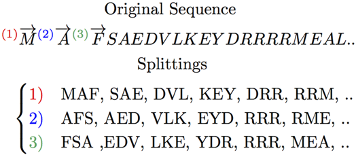

(5) Divide data into splits for multivariate LSTM time-series prediction, where m time steps are used as the input and n time steps are the output that is being predicted. 

In [ ]:
### Preprocessing Part 2 ###

# Import embeddings CSV and create embeddings dictionary
def setup_embeds(file_path):
  with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    embeddings = {}
    for row in csv_reader:
      temp = (row[0].split('\t'))
      nums = temp[1:]
      nums = np.array([float(num) for num in nums])
      nums = nums.reshape((100, 1))
      embeddings[temp[0]] = nums
  return embeddings


embed_dict = setup_embeds(pretrained_embedding_file_path)


# Create 3-gram splittings with overlap
def split_seq(sequence):
  # Take as input a sequence string and output splits as list 
  split_list = [] 
  for i in range(3):
    for j in range(0, len(sequence), 3):
      if j+i+3 <= len(sequence):
        split_list.append(sequence[j+i:j+i+3])
  return split_list


# Embed the protein
def embed(sequence, embed_dict):
  sequence_vec = np.zeros((100, 1))
  split_list = split_seq(sequence)
  for three_gram in split_list:
    vec_three_gram = embed_dict[three_gram]
    sequence_vec = sequence_vec + vec_three_gram
  return sequence_vec

# Embed all proteins in FASTA file and export as CSV
def embed_all(fasta_list, file_path):
  sequence_vecs = {}
  for seq_record in fasta_list:
    sequence = str(seq_record.seq)
    id = seq_record.id
    sequence_vec = embed(sequence, embed_dict)
    sequence_vecs[id] = sequence_vec

  with open(file_path, "w") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in sequence_vecs.items():
      writer.writerow([key, value])


embed_all(data3, csv_file_path)
